# Ford GoBike Data Explanation
## by Emefiele-konyeri Awinrin

## Investigation Overview
In this investigation, i want to find out how a period of time(hour,day,month) could affect the duration of trips and demand for bikes, what distance different users cover from the start station to the end station, what geographical area is this bike system more popular and how well users use the 'Bikeshare For All' program

## Dataset Overview
The Ford Gobike system data consists of 631,793 observations and 14 features('duration_sec', 'start_time', 'end_time', 'start_station_id', 'start_station_name', 'start_station_latitude', 'start_station_longitude', 'end_station_id', 'end_station_name', 'end_station_latitude', 'end_station_longitude', 'bike_id', 'user_type', 'bike_share_for_all_trip'), after data cleaning the dataset was transformed to 482,555 observations and 23 features(additional features: 'start_neighbourhood', 'start_city', 'end_neighbourhood', 'end_city', 'distances(km)', 'start_date', 'start_hour', 'start_day', 'duration_min').

In [2]:
# import all packages and set plots to be embedded inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
import seaborn as sb
from pandas.api.types import CategoricalDtype

%matplotlib inline

# suppress warnings from final output
import warnings
warnings.simplefilter("ignore")

In [3]:
# load in the dataset into a pandas dataframe
# Data downloaded from AWS
bikeshare1 = pd.read_csv('201901-fordgobike-tripdata.csv')
bikeshare2 = pd.read_csv('201902-fordgobike-tripdata.csv')
bikeshare3 = pd.read_csv('201903-fordgobike-tripdata.csv')

In [4]:
# merging all dataframes
bikeshare = pd.concat([bikeshare1,bikeshare2,bikeshare3])

In [6]:
# Making a copy of original piece of data
bikeshare_clean = bikeshare.copy()

In [7]:
# changing strings to datetime and int to strings
bikeshare_clean['start_time'] = pd.to_datetime(bikeshare_clean['start_time'])
bikeshare_clean['end_time'] = pd.to_datetime(bikeshare_clean['end_time'])
bikeshare_clean['start_station_id'] = bikeshare_clean['start_station_id'].astype(str).str[:-2]
bikeshare_clean['end_station_id'] = bikeshare_clean['end_station_id'].astype(str).str[:-2]
bikeshare_clean['bike_id'] = bikeshare_clean['bike_id'].astype(str)

In [8]:
# dropping null values
bikeshare_clean = bikeshare_clean.dropna()

In [9]:
# using the geopy python library to locate areas based on the coordinates provided
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from geopy.distance import geodesic

geolocator = Nominatim(user_agent="bikeshare")
reverse = RateLimiter(geolocator.reverse, min_delay_seconds=1, max_retries=0)

In [10]:
# removing duplicate start station ids to get each station's unique coordinates
bikeshare_start = bikeshare_clean[['start_station_id','start_station_name','start_station_latitude',
                      'start_station_longitude']].drop_duplicates(subset = ['start_station_id'])
bikeshare_start.set_index('start_station_id',inplace=True)

In [11]:
# removing duplicate end station ids to get each station's unique coordinates
bikeshare_end = bikeshare_clean[['end_station_id','end_station_name','end_station_latitude',
                      'end_station_longitude']].drop_duplicates(subset = ['end_station_id'])
bikeshare_end.set_index('end_station_id',inplace=True)

In [12]:
# using the itertuples function to iterate rows and columns in order to get each coordinate pair
start_locations = []
for row in bikeshare_start.itertuples():
    start_locations.append(reverse("{},{}".format(row.start_station_latitude,row.start_station_longitude)).raw['address'])

# using the itertuples function to iterate rows and columns in order to get each coordinate pair
end_locations = []
for row in bikeshare_end.itertuples():
    end_locations.append(reverse("{},{}".format(row.end_station_latitude,row.end_station_longitude)).raw['address'])   

In [18]:
# creating a dataframe from the retrieved data above
bikeshare_start_locations = pd.DataFrame(index = bikeshare_start.index,data = start_locations)
bikeshare_start_locations = bikeshare_start_locations[['neighbourhood','city']]
bikeshare_start_locations.columns = ['start_neighbourhood','start_city']
bikeshare_start_locations.index.names = ['start_station_id']
bikeshare_start_locations.index = bikeshare_start_locations.index.astype(str)

bikeshare_end_locations = pd.DataFrame(index = bikeshare_end.index,data = end_locations)
bikeshare_end_locations = bikeshare_end_locations[['neighbourhood','city']]
bikeshare_end_locations.columns = ['end_neighbourhood','end_city']
bikeshare_end_locations.index.names = ['end_station_id']
bikeshare_end_locations.index = bikeshare_end_locations.index.astype(str)

In [16]:
# using a geodesic function from the geopy library to get the distance between each start station and end station
locations = []
for row in bikeshare_clean.itertuples():
    start_station_coordinate = (row.start_station_latitude,row.start_station_longitude)
    end_station_coordinate = (row.end_station_latitude,row.end_station_longitude)
    locations.append(geodesic(start_station_coordinate,end_station_coordinate).km)

In [17]:
# creating a dataframe from the retrieved data above
bikeshare_distances = pd.DataFrame(data=locations)
bikeshare_distances.columns = ['distances(km)']

In [19]:
# merging all dataframe created above for tidiness and to form a master dataset
bikeshare_master = pd.merge(bikeshare_clean,bikeshare_start_locations,how='left',on='start_station_id')
bikeshare_master = pd.merge(bikeshare_master,bikeshare_end_locations,how='left',on='end_station_id')
bikeshare_master = pd.merge(bikeshare_master,bikeshare_distances,how='left',left_index=True,right_index=True)

In [20]:
# dropping null values
bikeshare_master = bikeshare_master.dropna()

In [21]:
# let's get the start time in terms of day,hour and date
bikeshare_master['start_date'] = bikeshare_master['start_time'].dt.strftime('%Y-%m-%d')
bikeshare_master['start_hour'] = bikeshare_master['start_time'].dt.strftime('%H')
bikeshare_master['start_day'] = bikeshare_master['start_time'].dt.strftime('%A')

# converting the duration seconds to minutes
bikeshare_master['duration_min'] = bikeshare_master['duration_sec']/60

In [22]:
# ordering the days
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
daycat = pd.api.types.CategoricalDtype(ordered=True, categories=days)
bikeshare_master['start_day'] = bikeshare_master['start_day'].astype(daycat)

## Distribution Of Duration(minutes)

The distribution is postively skewed to the right with interpretation that the frequency of the time reduces with an increase in time. The peak frequency is at a time close to 10 minutes and from that time goes a gradual decrease in frequency

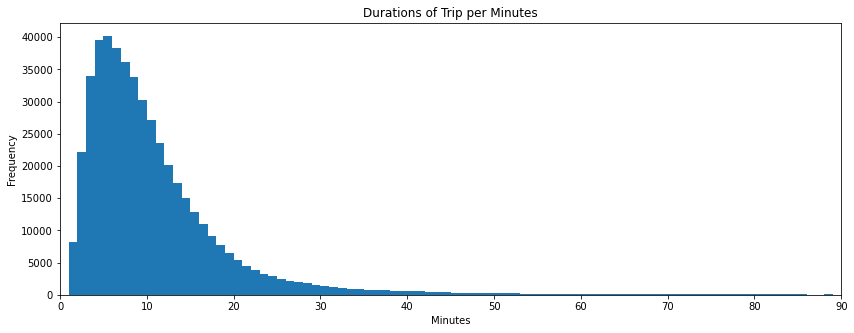

In [23]:
bins = np.arange(0,bikeshare_master['duration_min'].max(),1)
plt.figure(figsize=(14,5))
plt.hist(data = bikeshare_master,x='duration_min',bins=bins)
plt.xlim(0,90)
plt.xlabel('Minutes')
plt.ylabel('Frequency')
plt.title('Durations of Trip per Minutes');

## Distribution of Hour of the day with high demand for bikes

The distribution of this bar graph is bimodal which means in each day there will be two periods in time with very high demands for bikes. The two hours of the day with highest demands are 5PM and 8AM respectively.

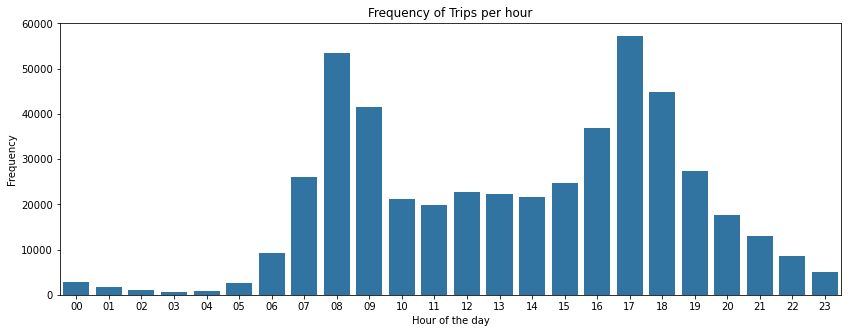

In [24]:
data = pd.DataFrame(bikeshare_master['start_hour'].sort_values(),columns=['start_hour'])
plt.figure(figsize=(14,5))
sb.countplot(data = data,x='start_hour',color=sb.color_palette()[0])
plt.xlabel('Hour of the day')
plt.ylabel('Frequency')
plt.title('Frequency of Trips per hour');

## Distribution day of the week with the high demands for bikes

The distribution shows a rise in demand from the start of the week until weekends, which means alot of the users are commuters going to work other than for recreation

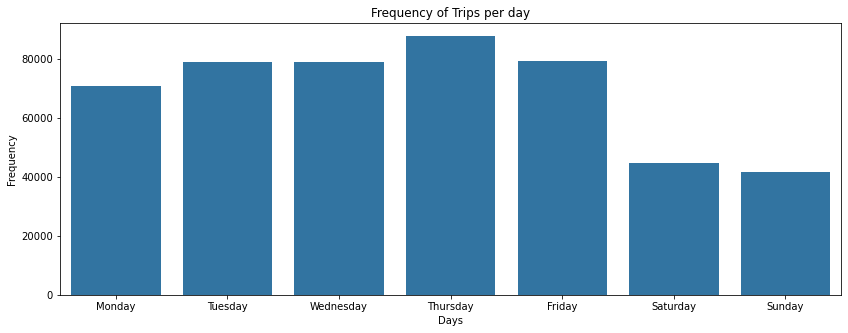

In [25]:
plt.figure(figsize=(14,5))
sb.countplot(data =bikeshare_master,x='start_day',color=sb.color_palette()[0],order=[ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'])
plt.xlabel('Days')
plt.ylabel('Frequency')
plt.title('Frequency of Trips per day');

## The average duration of trips of different users at each day of the week

Customers tend to have a higher duration of trips than Subscribers for every day of the week. Saturdays and Sundays seems to be the days with the highest average durations which not coincidentally is a weekend. Users spend more time on trips during the weekend maybe for recreation or for visitation and some sort.

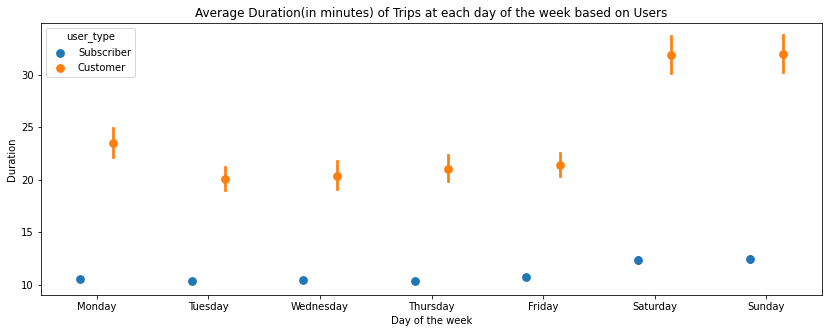

In [31]:
plt.figure(figsize=(14,5))
sb.pointplot(data = bikeshare_master,x='start_day',y='duration_min',hue='user_type',order=[ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],dodge = 0.3, linestyles = "")
plt.xlabel('Day of the week')
plt.ylabel('Duration')
plt.title('Average Duration(in minutes) of Trips at each day of the week based on Users');

## The time of the day different users demand bikes

During the weekends customers seems to be most users in demand for bikes with a concentration time around 10AM to 6PM while during weekdays subscribers seems to be the most in demand for bike at a conecentration time around 7AM to 9AM and 4PM to 6PM

<Figure size 432x288 with 0 Axes>

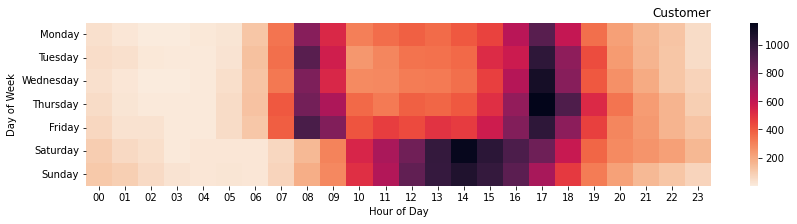

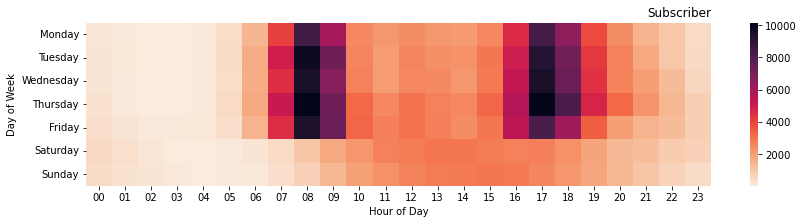

In [43]:

plt.suptitle('Hourly Usage during Weekdays for Customers and Subscribers')
fig,ax1 = plt.subplots(figsize=(14,3))
customers = bikeshare_master.query('user_type == "Customer"')
customers = customers.groupby(['start_day', 'start_hour']).size()
customers = customers.reset_index(name='count')
customers = customers.pivot(index='start_day', columns='start_hour', values='count')
sb.heatmap(customers, cmap='rocket_r',ax=ax1);
plt.title('Customer', loc='right');
plt.xlabel('Hour of Day');
plt.ylabel('Day of Week');

fig,ax2 = plt.subplots(figsize=(14,3))
subscribers = bikeshare_master.query('user_type == "Subscriber"')
subscribers = subscribers.groupby(['start_day', 'start_hour']).size()
subscribers = subscribers.reset_index(name='count')
subscribers = subscribers.pivot(index='start_day', columns='start_hour', values='count')
sb.heatmap(subscribers, cmap='rocket_r',ax=ax2);
plt.title('Subscriber', loc='right');
plt.xlabel('Hour of Day');
plt.ylabel('Day of Week');

##  Duration of trip for each day in the first quarter of the year

Even though there are variations in the trends we can still see an increase in peak of duration from january to march.

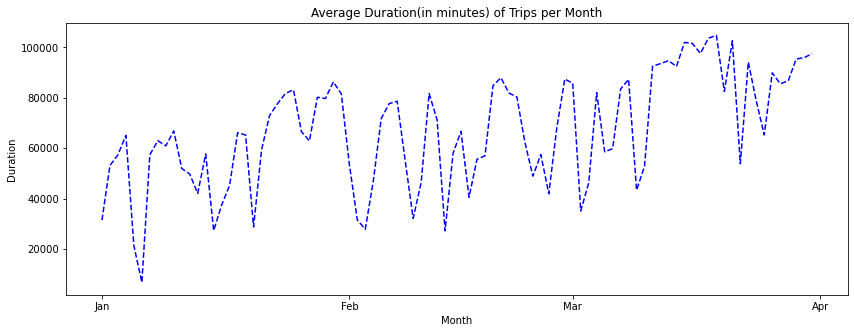

In [41]:
fig,ax = plt.subplots(figsize=(14,5))
c = bikeshare_master[['start_date','duration_min']].groupby('start_date').sum()
ax.plot(c.index,c['duration_min'],'b--')
ax.set_xlabel('Month')
ax.set_ylabel('Duration')
ax.set_title('Average Duration(in minutes) of Trips per Month');
date_form = DateFormatter("%b")
ax.xaxis.set_major_locator(mdates.MonthLocator())
ax.xaxis.set_major_formatter(date_form)

## Distribution of distance covered by each rider from the start station to the end station

The distribution is positively skewed to the right with the interpretation that the frequency of the distance from the start and end station(s) decreases with an increase in distance after a range between 0 to 1 kilometre. Which means most users tends to end their trip at a station not more than 2 kilometres from the start station.

(0.0, 10.0)

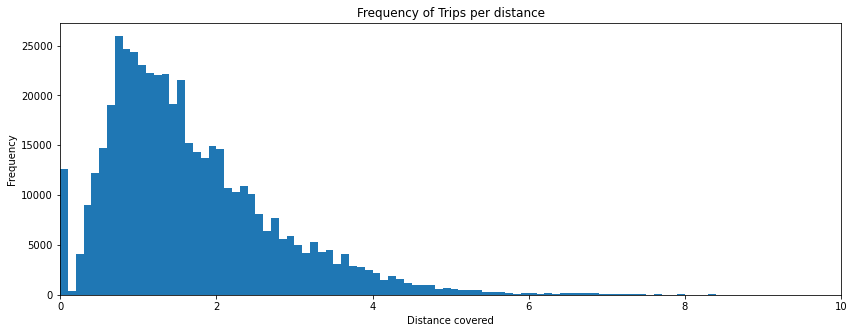

In [28]:
bins = np.arange(0,bikeshare_master['distances(km)'].max()+0.1,0.1)
plt.figure(figsize=(14,5))
plt.hist(data = bikeshare_master,x='distances(km)',bins=bins)
plt.xlabel('Distance covered')
plt.ylabel('Frequency')
plt.title('Frequency of Trips per distance');
plt.xlim(0,10)

## The average distance covered by each type of user from start station to end station

Customers have an average distance a little more than subscribers which doesn't really distinguish much about them

(-0.5, 10.0)

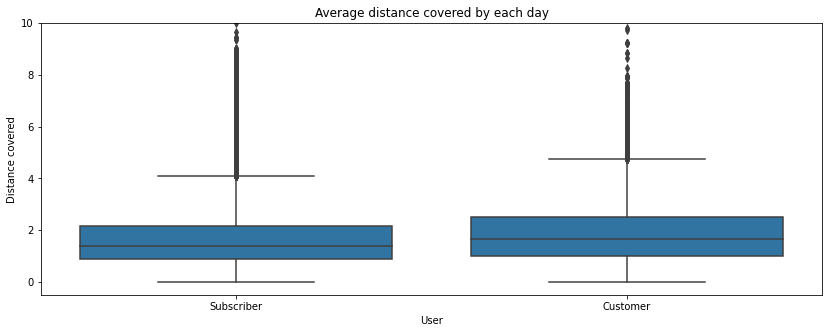

In [33]:
plt.figure(figsize=(14,5))
sb.boxplot(data = bikeshare_master,x='user_type',y='distances(km)',color=sb.color_palette()[0])
plt.xlabel('User')
plt.ylabel('Distance covered')
plt.title('Average distance covered by each day')
plt.ylim(-0.5,10)

## Top 20 neighbourhoods with the most demand for bikes

South Beach, Union Square and West Soma seems to be the outstanding neighbourhood in terms of demand for bikes with over 35,000 trips in each of both neighbourhoods

Text(0.5, 1.0, 'Top 20 Neighbourhoods based on number of trips')

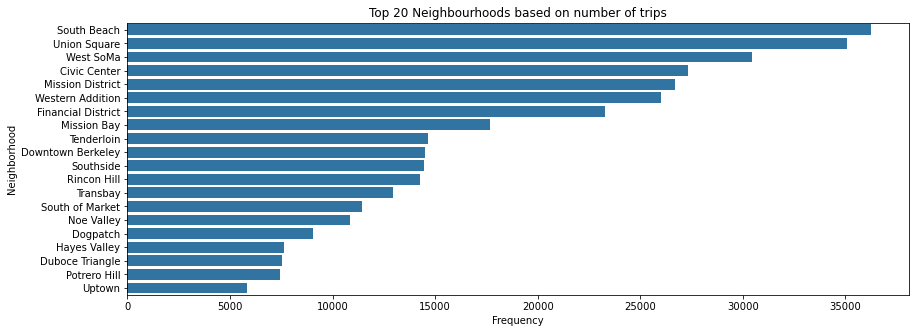

In [27]:
top_20 = bikeshare_master['start_neighbourhood'].value_counts()[:-63]
top_20 = pd.DataFrame(top_20)
plt.figure(figsize=(14,5))
sb.barplot(data =top_20,y=top_20.index,x=top_20.start_neighbourhood,color=sb.color_palette()[0])
plt.xlabel('Frequency')
plt.ylabel('Neighborhood')
plt.title('Top 20 Neighbourhoods based on number of trips')

## The proportion of bikeshare usage between each cities

San Francisco seems to be the major city were the Ford Gobike system is being used with 72% of the total number of trips in the nation.

Text(0.5, 1.0, 'Proportion of bikeshare usage between each cities')

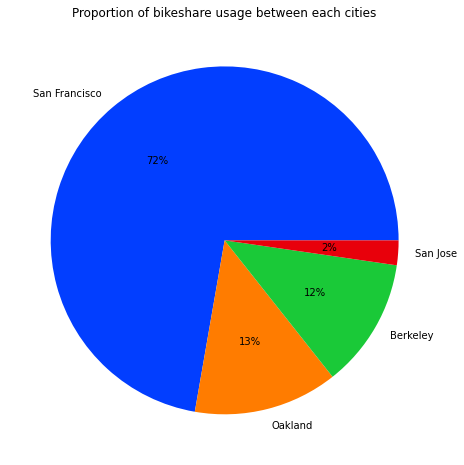

In [30]:
data = bikeshare_master['start_city'].value_counts()
value = list(data.values)
city = list(data.index)
plt.figure(figsize=(16,8))
plt.pie(data =data,x=value,labels=city,colors=sb.color_palette('bright'), autopct='%.0f%%')
plt.title('Proportion of bikeshare usage between each cities')

## The relationship between type of user and bikeshare for all trip membership plan

Most subscribers don't use bike share for all trip plan, customers don't use bikeshare for all trip plan. 'BikeShare For All' program is the nation’s most comprehensive bike share equity program, includes equitable station siting, outreach, and discounted pricing to help expand transportation access to underserved communities.

Text(0.5, 1.0, 'Frequency of trips based on type of user and if they use bikeshare for all trips')

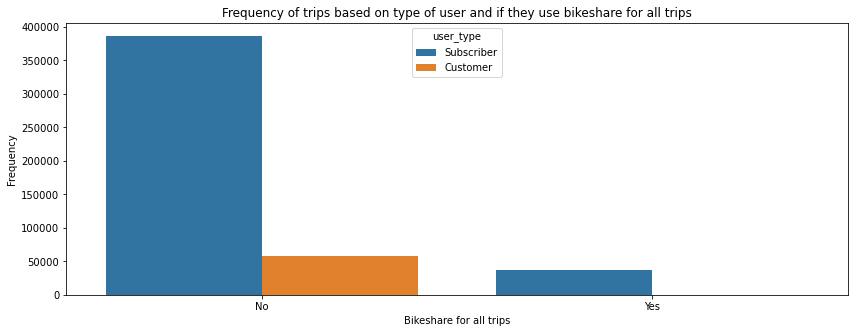

In [32]:
plt.figure(figsize=(14,5))
sb.countplot(data = bikeshare_master,x='bike_share_for_all_trip',hue='user_type')
plt.xlabel('Bikeshare for all trips')
plt.ylabel('Frequency')
plt.title('Frequency of trips based on type of user and if they use bikeshare for all trips')

>**Generate Slideshow**: Once you're ready to generate your slideshow, use the `jupyter nbconvert` command to generate the HTML slide show. . From the terminal or command line, use the following expression.

In [45]:
!jupyter nbconvert Part_II_slide_deck_template.ipynb --to slides --post serve --no-input --no-prompt

[NbConvertApp] Converting notebook Part_II_slide_deck_template.ipynb to slides
[NbConvertApp] Writing 828129 bytes to Part_II_slide_deck_template.slides.html
[NbConvertApp] Redirecting reveal.js requests to https://cdnjs.cloudflare.com/ajax/libs/reveal.js/3.5.0
Traceback (most recent call last):
  File "C:\Users\HP.PC\anaconda3\Scripts\jupyter-nbconvert-script.py", line 10, in <module>
    sys.exit(main())
  File "C:\Users\HP.PC\anaconda3\lib\site-packages\jupyter_core\application.py", line 264, in launch_instance
    return super(JupyterApp, cls).launch_instance(argv=argv, **kwargs)
  File "C:\Users\HP.PC\anaconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
    app.start()
  File "C:\Users\HP.PC\anaconda3\lib\site-packages\nbconvert\nbconvertapp.py", line 346, in start
    self.convert_notebooks()
  File "C:\Users\HP.PC\anaconda3\lib\site-packages\nbconvert\nbconvertapp.py", line 518, in convert_notebooks
    self.convert_single_notebook(notebook_